In [1]:
# General libraries
import os
import shutil
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# Setting seeds for reproducibility
seed = 232
np.random.seed(seed)
tf.random.set_seed(seed)

Using TensorFlow backend.


In [27]:
# Create directory, if directory exists remove and create one 

def create_directory(directory_path):
    if os.path.exists(directory_path):
        shutil.rmtree(directory_path) 
        os.mkdir(directory_path)
    else:
        os.mkdir(directory_path)

In [28]:
#moving files from one folder to other,     
def move_allfiles (src,dst):
    if os.path.exists(src):
        files = os.listdir(src) 
        for f in files:
            shutil.copyfile(src+f,dst+f)

In [29]:
#moving list of files from one folder to other,
def move_listfiles (src,dst,img_list):
    if os.path.exists(src):
        files = img_list
        for f in files:
            shutil.copyfile(src+f,dst+f)

In [30]:
#reading the data
df=pd.read_csv("Data_Entry_2017.csv") 

In [31]:
#renaming the columns names
df.rename(columns={'Image Index':'img_index','Finding Labels':'labels','Follow-up #':'follow_up','Patient ID':'pa_id',
                   'Patient Age':'pa_age','Patient Gender':'pa_gender','View Position':'view_position'}, inplace=True)

In [32]:
df.columns

Index(['img_index', 'labels', 'follow_up', 'pa_id', 'pa_age', 'pa_gender',
       'view_position', 'OriginalImage[Width', 'Height]',
       'OriginalImagePixelSpacing[x', 'y]'],
      dtype='object')

In [33]:
#convert the files in train_val_list.txt to a python list 

train_val_list= open('/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/train_val_list.txt').read().split()
train_val_list[1:3]

['00000001_001.png', '00000001_002.png']

In [34]:
len(train_val_list)

86524

In [35]:
#Selecting the images under train_val_list from Data_Entry_2017.csv file

df_train_img = df[df.img_index.isin(train_val_list)]

In [36]:
df_train_img.head()
#following are the images to be trained

,img_index,labels,follow_up,pa_id,pa_age,pa_gender,view_position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168


In [37]:
len(df_train_img)

86524

In [38]:
#checking images with various labels
print(df_train_img['labels'].unique())

['Cardiomegaly' 'Cardiomegaly|Emphysema' 'Cardiomegaly|Effusion'
 'No Finding' 'Mass|Nodule' 'Infiltration' 'Effusion|Infiltration'
 'Nodule' 'Emphysema' 'Effusion' 'Atelectasis' 'Effusion|Mass'
 'Effusion|Infiltration|Nodule' 'Atelectasis|Effusion|Pleural_Thickening'
 'Pleural_Thickening' 'Fibrosis|Infiltration'
 'Fibrosis|Infiltration|Pleural_Thickening' 'Fibrosis'
 'Infiltration|Mass|Nodule' 'Atelectasis|Cardiomegaly|Fibrosis'
 'Atelectasis|Infiltration' 'Consolidation|Mass'
 'Consolidation|Effusion|Infiltration' 'Infiltration|Pleural_Thickening'
 'Atelectasis|Effusion' 'Fibrosis|Infiltration|Nodule' 'Nodule|Pneumonia'
 'Infiltration|Nodule' 'Mass' 'Effusion|Pleural_Thickening'
 'Edema|Effusion|Infiltration|Pleural_Thickening|Pneumonia'
 'Effusion|Fibrosis' 'Pneumonia' 'Edema|Effusion|Infiltration'
 'Edema|Effusion' 'Consolidation|Effusion|Infiltration|Mass'
 'Consolidation|Effusion|Infiltration|Nodule' 'Pneumothorax'
 'Atelectasis|Effusion|Infiltration' 'Effusion|Emphysema|Infiltra

In [39]:
#assign 1 for 'No Finding' and 2 for 'Cardiomegaly'
df_train_img.loc[df_train_img.labels.str.contains('No Finding'), 'marker'] = '1'

df_train_img.loc[df_train_img.labels.str.contains('Cardiomegaly'), 'marker'] = '2'



/Users/neeharikasinha/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/neeharikasinha/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [40]:
df_train_img.head()

,img_index,labels,follow_up,pa_id,pa_age,pa_gender,view_position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],marker
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,2
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,2
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,1
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,0.168,NaN


In [41]:
df_train_img.describe()

,follow_up,pa_id,pa_age,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
count,86524.000000,86524.000000,86524.000000,86524.000000,86524.000000,86524.000000,86524.000000
mean,5.096621,13795.359415,46.870071,2641.784129,2505.106121,0.155384,0.155384
std,8.656941,8261.548258,16.835434,337.139196,403.957467,0.015615,0.015615
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000
25%,0.000000,6773.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000
50%,2.000000,13352.500000,49.000000,2520.000000,2544.000000,0.143000,0.143000
75%,6.000000,20185.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000
max,108.000000,30801.000000,413.000000,3550.000000,3166.000000,0.198800,0.198800


In [42]:
df_normal=df_train_img[df_train_img['marker'] == '1']

In [43]:
df_cardiomegaly=df_train_img[df_train_img['marker'] == '2']

In [44]:
df_normal.head()

,img_index,labels,follow_up,pa_id,pa_age,pa_gender,view_position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],marker
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,1
13,00000005_000.png,No Finding,0,5,69,F,PA,2048,2500,0.168,0.168,1
14,00000005_001.png,No Finding,1,5,69,F,AP,2500,2048,0.168,0.168,1
15,00000005_002.png,No Finding,2,5,69,F,AP,2500,2048,0.168,0.168,1
16,00000005_003.png,No Finding,3,5,69,F,PA,2992,2991,0.143,0.143,1


In [45]:
df_cardiomegaly.head()

,img_index,labels,follow_up,pa_id,pa_age,pa_gender,view_position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],marker
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,2
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,2
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,2
23,00000008_000.png,Cardiomegaly,0,8,69,F,PA,2048,2500,0.171,0.171,2
175,00000033_000.png,Atelectasis|Cardiomegaly|Fibrosis,0,33,72,F,PA,2992,2745,0.143,0.143,2


In [46]:
#number of images which do not come under normal or cardiomegaly
print('Number of images which do not come under normal or cardiomegaly:',len(df_train_img)-(len(df_normal)+len(df_cardiomegaly)))

Number of images which do not come under normal or cardiomegaly: 34317


In [47]:
#number of raw images being analysed
print('Number of raw images being analysed:',len(df_normal)+len(df_cardiomegaly))


Number of raw images being analysed: 52207


In [48]:
#making list of images under normal
normal_img_list = df_normal.img_index.tolist()
normal_img_list[1:3]

['00000005_000.png', '00000005_001.png']

In [49]:
#making list of images under cardiomegaly
cardiomegaly_img_list = df_cardiomegaly.img_index.tolist()
cardiomegaly_img_list[1:3]

['00000001_001.png', '00000001_002.png']

In [50]:
#create a folder train_img to collect all the images belonging to train_val_list.txt
create_directory('/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/train_img/')

In [51]:
#move the images in train_img
move_listfiles('/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/img_all/','/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/train_img/',train_val_list)

In [52]:
#ctreate folder normal_img
create_directory('/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/normal_img/')

In [53]:
#moving images marked as normal from train_img to normal

move_listfiles('/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/train_img/','/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/normal_img/',normal_img_list)

In [54]:
#moving images marked as cardiomegaly from train_img to cardiomegaly

move_listfiles('/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/train_img/','/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/cardiomegaly_img/',cardiomegaly_img_list)

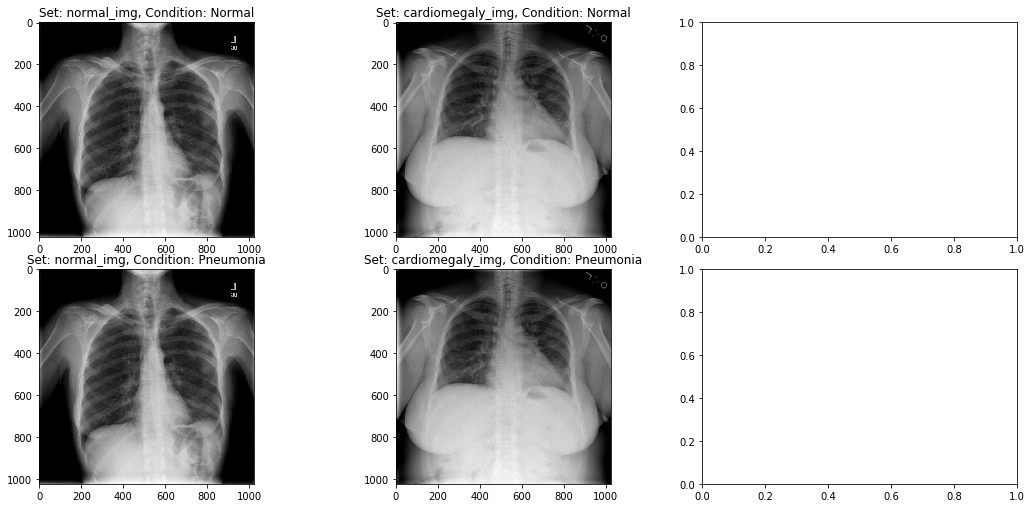

In [20]:
#take a view of some sample images
#Nate: I have created 2 folders  marked as 'cardiomegaly_img' and 'normal_img'. The nest step is to randomly select 3 
#from the folder and print.I am following the link "https://github.com/abhinavsagar/Kaggle-Solutions/blob/master/Chest_X-Ray.ipynb"
# but it seems there is a "val" folder too. I images are not correct, the cardiomegaly image is marked as Normal.

input_path = '/Users/neeharikasinha/Documents/datascience-course/Chestxray-cardiomegaly_final/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['normal_img', 'cardiomegaly_img']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/'+os.listdir(set_path+'/')[0]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/'+os.listdir(set_path+'/')[0]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))
   
    